# Yiannis Karavellas 4228

# Usefull functions and data loading

importing libaries and data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import numpy as np

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
# Hyperparameters
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download and create training and test sets
train_dataset = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


function to compare original with reconstructed imgages

In [2]:
def show_reconstructed_images(model, data_loader, device='cpu', num_images=5):
    model.eval()
    images, _ = next(iter(data_loader))
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)

    images = images.cpu().numpy()
    outputs = outputs.cpu().numpy()

    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(12, 4))
    for i in range(num_images):
        # Original
        axes[0, i].imshow(images[i].reshape(28, 28), cmap='gray')
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        if i == 0:
            axes[0, i].set_ylabel("Original")

        # Reconstructed
        axes[1, i].imshow(outputs[i].reshape(28, 28), cmap='gray')
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])
        if i == 0:
            axes[1, i].set_ylabel("Reconstructed")

    plt.show()



function for 2D plotting  the latent space

In [3]:
def get_latent_representations(model, data_loader, device='cpu', max_samples=10000):
    model.eval()
    latent_vectors = []
    all_labels = []
    
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            # Get latent representations
            encoded = model.encode(images)
            
            latent_vectors.append(encoded.cpu())
            all_labels.append(labels)
            
            total_samples += images.size(0)
            if total_samples >= max_samples:
                break
    
    # Concatenate all batches into a single tensor
    latent_vectors = torch.cat(latent_vectors, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # If we've exceeded max_samples, slice down
    if latent_vectors.size(0) > max_samples:
        latent_vectors = latent_vectors[:max_samples]
        all_labels = all_labels[:max_samples]
    
    return latent_vectors, all_labels

from sklearn.manifold import TSNE

def visualize_tsne(latent_vectors, labels):

    latent_np = latent_vectors.numpy()  # convert to NumPy
    labels_np = labels.numpy()
    
    # Perform t-SNE
    tsne = TSNE(n_components=2, learning_rate='auto', init='random',random_state=42)
    embeddings_2d = tsne.fit_transform(latent_np)
    
    return embeddings_2d, labels_np

def plot_2d_embeddings(embeddings_2d, labels):

    plt.figure(figsize=(8, 6))
    
    scatter = plt.scatter(
        embeddings_2d[:, 0],
        embeddings_2d[:, 1],
        c=labels,
        cmap='tab10',
        alpha=0.7,
        s=10
    )
    
    legend1 = plt.legend(*scatter.legend_elements(), loc="best", title="Digits")
    plt.gca().add_artist(legend1)
    
    plt.title("Latent Space Visualization")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

evaluation function for the autoencoders

In [4]:
def evaluate_autoencoder(model, test_loader, device='cpu'):
    model.eval()
    criterion = nn.MSELoss() 
    running_test_loss = 0.0
    
    # Dictionary to store loss per digit
    digit_loss = {i: {'total_loss': 0.0, 'count': 0} for i in range(10)}
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            # Get reconstructions
            outputs = model(images)
            
            loss = criterion(outputs, images)
            running_test_loss += loss.item() * images.size(0)
            
            # Calculate loss per digit class
            for img, label, output in zip(images, labels, outputs):
                img = img.unsqueeze(0)  # Add batch dimension
                output = output.unsqueeze(0)
                digit_loss[label.item()]['total_loss'] += criterion(output, img).item() * img.size(0)
                digit_loss[label.item()]['count'] += img.size(0)
    
    # Calculate average loss exactly as in training loop
    avg_test_loss = running_test_loss / len(test_loader.dataset)
    
    # Calculate average loss per digit
    digit_avg_loss = {digit: info['total_loss'] / info['count'] 
                        for digit, info in digit_loss.items()}
    
    print(f"\nOverall Test Set Loss: {avg_test_loss:.6f}")
    print("\nLoss per digit:")
    for digit, loss in digit_avg_loss.items():
        print(f"Digit {digit}: {loss:.6f}")
        
    return avg_test_loss, digit_avg_loss

 Convert the MNIST dataset to a numpy array

In [5]:
def dataset_to_numpy(dataset):
    
    all_images = []
    all_labels = []
    for img, label in dataset:
        arr = np.array(img, dtype=np.float32).reshape(-1)  # flatten to 784
        all_images.append(arr)
        all_labels.append(label)
    
    # Stack into [N, 784]
    all_images = np.stack(all_images, axis=0)
    all_labels = np.array(all_labels, dtype=np.int64)
    return all_images, all_labels

# Convert datasets to numpy and normalize

# Basic Autoencoder

Define the model

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, latent=32):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, latent),
            nn.ReLU(True),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  
        )

    def forward(self, x):
        # Flatten the image into a vector
        x = x.view(x.size(0), -1)  # shape = (batch_size, 784)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # Reshape back to (batch_size, 1, 28, 28) 
        decoded = decoded.view(x.size(0), 1, 28, 28)
        return decoded
    def encode(self, x):
        # Flatten first
        x = x.view(x.size(0), -1)
        # Return only the latent representation
        return self.encoder(x)

training

In [7]:
def train_autoencoder(model, train_loader, test_loader, num_epochs=10, learning_rate=1e-3, device='cpu'):
    # Move the model to device
    model = model.to(device)
    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    # Training loop
    for epoch in range(num_epochs):

        model.train()  # set to training mode
        running_train_loss = 0.0

        for images, _ in train_loader:
            images = images.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, images)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Training loss
            running_train_loss += loss.item() * images.size(0)

        # Compute average training loss over all training samples
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()  # set to evaluation mode
        running_test_loss = 0.0

        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)

                # Test loss
                running_test_loss += loss.item() * images.size(0)

        # Compute average test loss
        epoch_test_loss = running_test_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
                f"Train Loss: {epoch_train_loss:.4f}, "
                f"Test Loss: {epoch_test_loss:.4f}")

    return train_losses, test_losses

usage example

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_shallow = Autoencoder(input_dim=784, hidden_dim=128, latent=64)

num_epochs = 10
learning_rate = 1e-3

train_losses, test_losses = train_autoencoder(
    model_shallow, train_loader, test_loader,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    device=device
)

Epoch [1/10], Train Loss: 0.0377, Test Loss: 0.0194
Epoch [2/10], Train Loss: 0.0165, Test Loss: 0.0138
Epoch [3/10], Train Loss: 0.0128, Test Loss: 0.0112
Epoch [4/10], Train Loss: 0.0107, Test Loss: 0.0096
Epoch [5/10], Train Loss: 0.0093, Test Loss: 0.0085
Epoch [6/10], Train Loss: 0.0084, Test Loss: 0.0077
Epoch [7/10], Train Loss: 0.0077, Test Loss: 0.0072
Epoch [8/10], Train Loss: 0.0073, Test Loss: 0.0068
Epoch [9/10], Train Loss: 0.0069, Test Loss: 0.0066
Epoch [10/10], Train Loss: 0.0066, Test Loss: 0.0063


evaluation

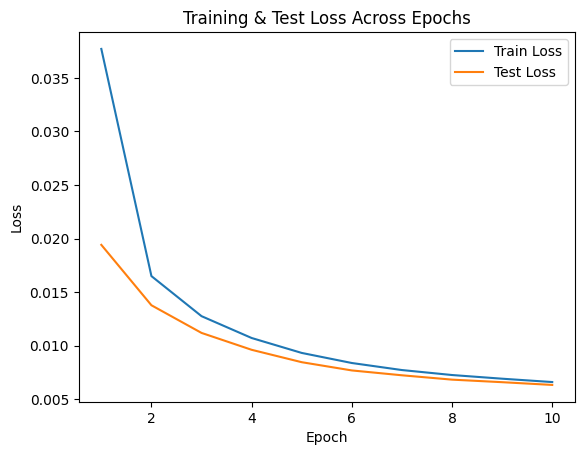

In [9]:
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Test Loss Across Epochs')
plt.show()

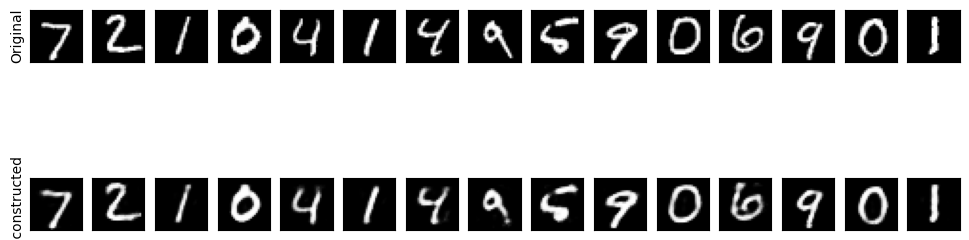

In [10]:
show_reconstructed_images(model_shallow, test_loader, device=device, num_images=15)

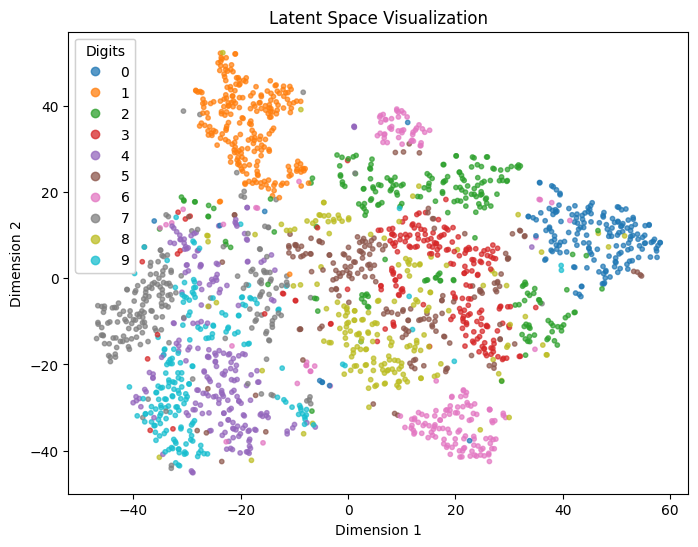

In [11]:

latent_vectors, labels = get_latent_representations(
    model_shallow, test_loader, device=device, max_samples=2000
)

embeddings_2d, labels_np = visualize_tsne(latent_vectors, labels)

plot_2d_embeddings(embeddings_2d, labels_np)


Overall Test Set Loss: 0.006343

Loss per digit:
Digit 0: 0.006805
Digit 1: 0.001953
Digit 2: 0.008687
Digit 3: 0.006928
Digit 4: 0.006675
Digit 5: 0.007584
Digit 6: 0.006907
Digit 7: 0.004792
Digit 8: 0.008854
Digit 9: 0.005047


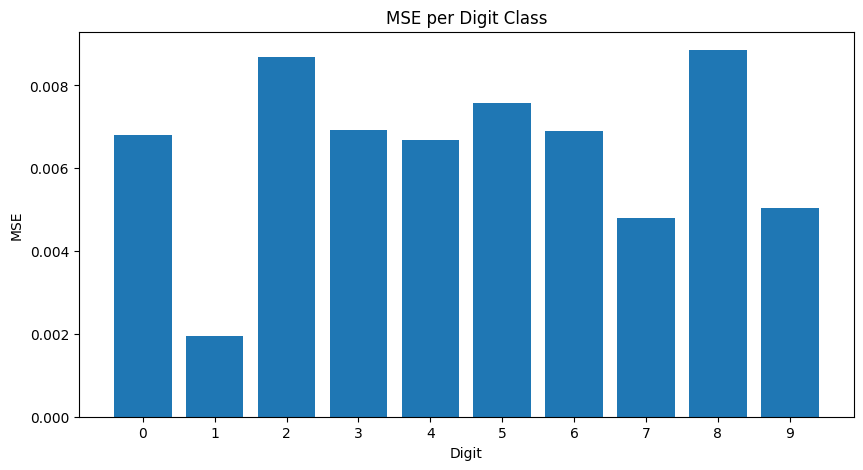

In [12]:
test_mse, digit_mse = evaluate_autoencoder(model_shallow, test_loader, device)

plt.figure(figsize=(10, 5))
plt.bar(digit_mse.keys(), digit_mse.values())
plt.title('MSE per Digit Class')
plt.xlabel('Digit')
plt.ylabel('MSE')
plt.xticks(range(10), labels=range(10))
plt.show()

# Deeper autoencoder

Definition of the model

In [13]:
class DeeperAutoencoder(nn.Module):
    def __init__(self):
        super(DeeperAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True) 
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Sigmoid() 
        )
        
    def forward(self, x):

        x = x.view(x.size(0), -1)
        
        encoded = self.encoder(x)
        
        decoded = self.decoder(encoded)

        decoded = decoded.view(x.size(0), 1, 28, 28)
        return decoded
    
    def encode(self, x):
        # Flatten first
        x = x.view(x.size(0), -1)
        # Return only the latent representation
        return self.encoder(x)

training function

In [14]:
def train_deeper_autoencoder(model, train_loader, test_loader, 
                                num_epochs=10, learning_rate=1e-3, device='cpu'):
    
    model.to(device)
    criterion = nn.MSELoss()               
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        
        for images, _ in train_loader:
            images = images.to(device)
            
            # Forward
            outputs = model(images)
            loss = criterion(outputs, images)
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * images.size(0)
        
        # Average train loss
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        model.eval()
        running_test_loss = 0.0
        
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                running_test_loss += loss.item() * images.size(0)
        
        # Average test loss
        epoch_test_loss = running_test_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)
        
        # Print losses for this epoch
        print(f"Epoch [{epoch+1}/{num_epochs}] "
                f"Train Loss: {epoch_train_loss:.4f} "
                f"Test Loss: {epoch_test_loss:.4f}")
    
    return train_losses, test_losses

autoencoder = DeeperAutoencoder().to(device)

Epoch [1/20] Train Loss: 0.0359 Test Loss: 0.0197
Epoch [2/20] Train Loss: 0.0162 Test Loss: 0.0134
Epoch [3/20] Train Loss: 0.0120 Test Loss: 0.0106
Epoch [4/20] Train Loss: 0.0099 Test Loss: 0.0091
Epoch [5/20] Train Loss: 0.0088 Test Loss: 0.0083
Epoch [6/20] Train Loss: 0.0080 Test Loss: 0.0077
Epoch [7/20] Train Loss: 0.0075 Test Loss: 0.0074
Epoch [8/20] Train Loss: 0.0070 Test Loss: 0.0070
Epoch [9/20] Train Loss: 0.0067 Test Loss: 0.0071
Epoch [10/20] Train Loss: 0.0064 Test Loss: 0.0065
Epoch [11/20] Train Loss: 0.0062 Test Loss: 0.0063
Epoch [12/20] Train Loss: 0.0060 Test Loss: 0.0062
Epoch [13/20] Train Loss: 0.0058 Test Loss: 0.0061
Epoch [14/20] Train Loss: 0.0057 Test Loss: 0.0058
Epoch [15/20] Train Loss: 0.0056 Test Loss: 0.0063
Epoch [16/20] Train Loss: 0.0054 Test Loss: 0.0057
Epoch [17/20] Train Loss: 0.0053 Test Loss: 0.0056
Epoch [18/20] Train Loss: 0.0053 Test Loss: 0.0055
Epoch [19/20] Train Loss: 0.0052 Test Loss: 0.0054
Epoch [20/20] Train Loss: 0.0051 Test Lo

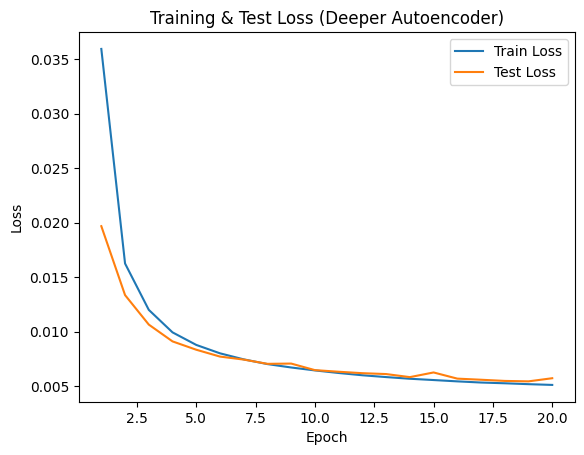

In [15]:
# Instantiate our deeper autoencoder
model_deep = DeeperAutoencoder()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
num_epochs = 20
learning_rate = 1e-3


train_losses, test_losses = train_deeper_autoencoder(
    model=model_deep,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    device=device
)

# Plot the training and test loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Test Loss (Deeper Autoencoder)')
plt.show()

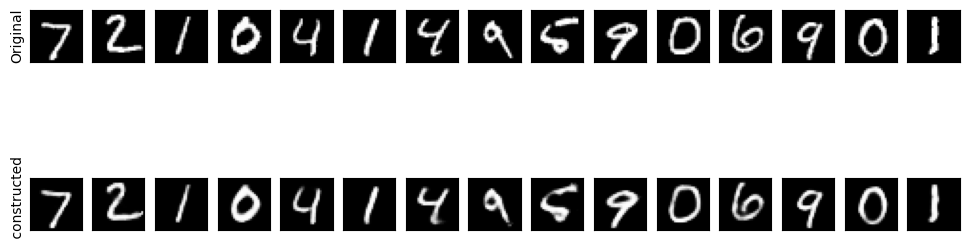

In [16]:
show_reconstructed_images(model_deep, test_loader, device=device, num_images=15)

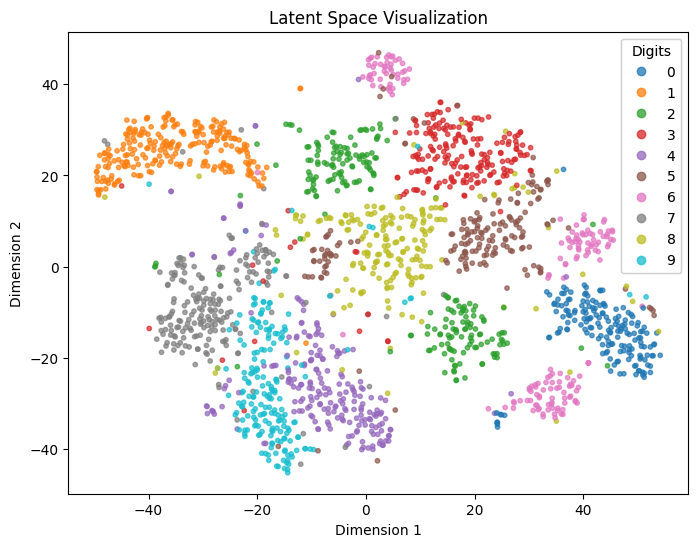

In [17]:

latent_vectors, labels = get_latent_representations(
    model_deep, test_loader, device=device, max_samples=2000
)

embeddings_2d, labels_np = visualize_tsne(latent_vectors, labels)

plot_2d_embeddings(embeddings_2d, labels_np)


Overall Test Set Loss: 0.005722

Loss per digit:
Digit 0: 0.006530
Digit 1: 0.001738
Digit 2: 0.007631
Digit 3: 0.006318
Digit 4: 0.005745
Digit 5: 0.006871
Digit 6: 0.006290
Digit 7: 0.004207
Digit 8: 0.007914
Digit 9: 0.004718


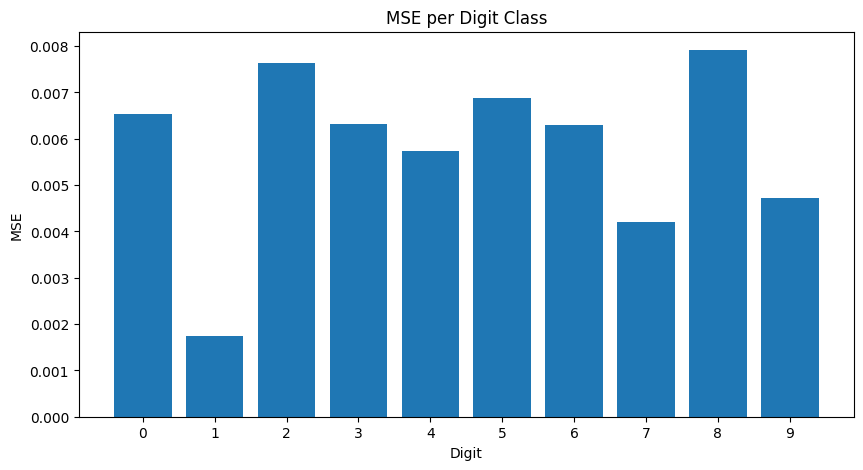

In [18]:
test_mse, digit_mse = evaluate_autoencoder(model_deep, test_loader, device)

plt.figure(figsize=(10, 5))
plt.bar(digit_mse.keys(), digit_mse.values())
plt.title('MSE per Digit Class')
plt.xlabel('Digit')
plt.ylabel('MSE')
plt.xticks(range(10), labels=range(10))
plt.show()

# PCA implementation

In [19]:
train_images_np, train_labels_np = dataset_to_numpy(train_dataset)
test_images_np, test_labels_np = dataset_to_numpy(test_dataset)


print(f"Normalized train images range: [{train_images_np.min():.6f}, {train_images_np.max():.6f}]")
print(f"Normalized test images range: [{test_images_np.min():.6f}, {test_images_np.max():.6f}]")



Normalized train images range: [0.000000, 1.000000]
Normalized test images range: [0.000000, 1.000000]


In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=64)  # match autoencoder's bottleneck dimension
pca.fit(train_images_np) 

# Transform and reconstruct test images
test_comp = pca.transform(test_images_np)  
test_recon = pca.inverse_transform(test_comp)  



In [21]:
def calculate_pca_mse(original_images, reconstructed_images):
    
    running_loss = 0.0
    total_samples = len(original_images)
    
    # Convert to PyTorch tensors to use the same MSE calculation
    original_tensor = torch.FloatTensor(original_images)  # Keep as flattened
    reconstructed_tensor = torch.FloatTensor(reconstructed_images)  # Keep as flattened
    
    # Use the same criterion as in autoencoder
    criterion = nn.MSELoss()
    
    # Calculate loss batch by batch to match autoencoder's calculation
    batch_size = 64  # Same as autoencoder
    for i in range(0, total_samples, batch_size):
        batch_end = min(i + batch_size, total_samples)
        batch_original = original_tensor[i:batch_end]
        batch_reconstructed = reconstructed_tensor[i:batch_end]
        
        # Calculate loss exactly as in autoencoder training loop
        loss = criterion(batch_reconstructed, batch_original)
        running_loss += loss.item() * batch_original.size(0)
        
    # Calculate final average loss
    avg_loss = running_loss / total_samples
    
    return avg_loss


# Fit PCA and get reconstructions
pca = PCA(n_components=64)
pca.fit(train_images_np)
test_proj = pca.transform(test_images_np)
test_recon = pca.inverse_transform(test_proj)

# Calculate PCA MSE using the same method as autoencoder
pca_mse = calculate_pca_mse(test_images_np, test_recon)
print(f"PCA Test MSE: {pca_mse:.6f}")

PCA Test MSE: 0.009047


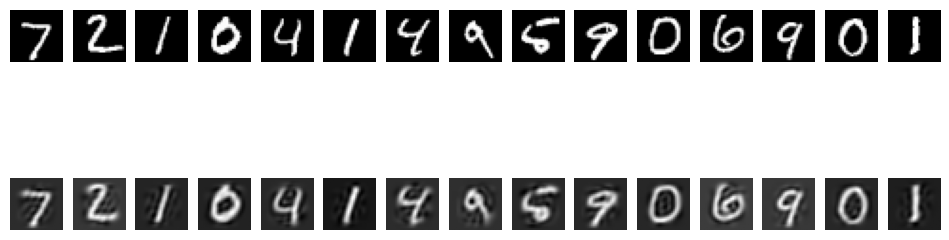

In [22]:
# Visualize reconstructions
num_images = 15
fig, axes = plt.subplots(2, num_images, figsize=(12, 4))

for i in range(num_images):
    # Original
    axes[0, i].imshow(test_images_np[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0: 
        axes[0, i].set_ylabel('Original')
    
    # Reconstructed
    axes[1, i].imshow(test_recon[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0: 
        axes[1, i].set_ylabel('Reconstructed')

plt.show()

# Classification

Defining the CNN model

In [23]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 14x14 -> 7x7
        )

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Pass input through the convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)

        # Flatten
        x = x.view(x.size(0), -1) 

        # Pass through fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

Training loop

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cnn_classifier = CNN(num_classes=10).to(device)
learning_rate=0.001
num_epochs=10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn_classifier.parameters(), lr=learning_rate)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    return (predicted == labels).float().mean()

for epoch in range(num_epochs):

    model_cnn_classifier.train()
    running_loss = 0.0
    running_acc = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model_cnn_classifier(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels).item()

    avg_train_loss = running_loss / len(train_loader)
    avg_train_acc = running_acc / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # evaluation
    model_cnn_classifier.eval()
    test_running_loss = 0.0
    test_running_acc = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_cnn_classifier(images)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item()
            test_running_acc += accuracy(outputs, labels).item()

    avg_test_loss = test_running_loss / len(test_loader)
    avg_test_acc = test_running_acc / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracies.append(avg_test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc*100:.2f}%, "
            f"Test Loss: {avg_test_loss:.4f}, Test Acc: {avg_test_acc*100:.2f}%")
    



Epoch [1/10], Train Loss: 0.1662, Train Acc: 94.96%, Test Loss: 0.0641, Test Acc: 97.75%
Epoch [2/10], Train Loss: 0.0476, Train Acc: 98.50%, Test Loss: 0.0376, Test Acc: 98.72%
Epoch [3/10], Train Loss: 0.0318, Train Acc: 99.01%, Test Loss: 0.0315, Test Acc: 98.86%
Epoch [4/10], Train Loss: 0.0227, Train Acc: 99.31%, Test Loss: 0.0263, Test Acc: 99.17%
Epoch [5/10], Train Loss: 0.0177, Train Acc: 99.42%, Test Loss: 0.0290, Test Acc: 99.00%
Epoch [6/10], Train Loss: 0.0144, Train Acc: 99.54%, Test Loss: 0.0375, Test Acc: 98.94%
Epoch [7/10], Train Loss: 0.0119, Train Acc: 99.57%, Test Loss: 0.0399, Test Acc: 98.91%
Epoch [8/10], Train Loss: 0.0093, Train Acc: 99.68%, Test Loss: 0.0367, Test Acc: 98.99%
Epoch [9/10], Train Loss: 0.0077, Train Acc: 99.75%, Test Loss: 0.0325, Test Acc: 99.09%
Epoch [10/10], Train Loss: 0.0078, Train Acc: 99.74%, Test Loss: 0.0431, Test Acc: 98.89%


Printing the results

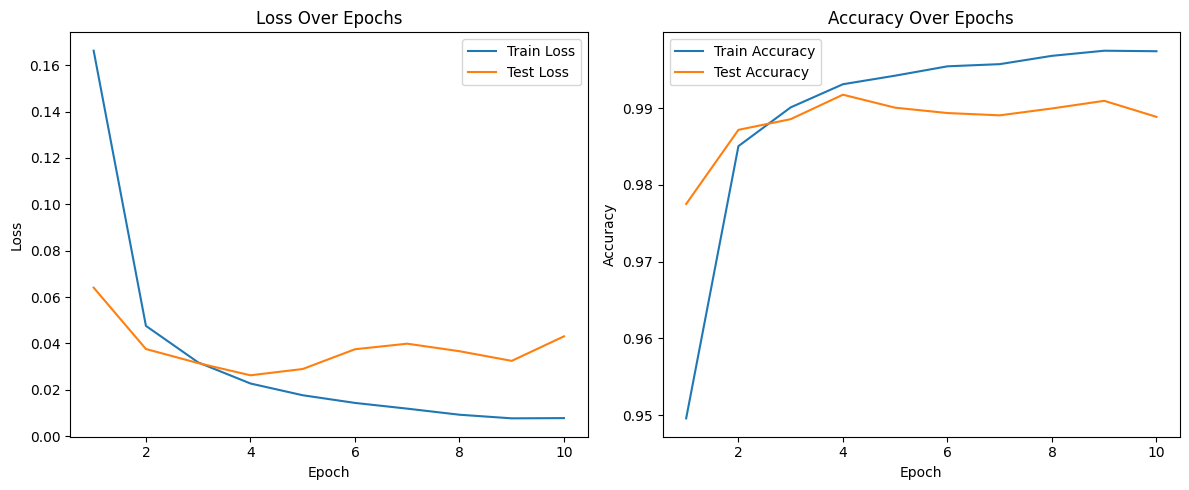

In [25]:
epochs_range = range(1, num_epochs+1)

plt.figure(figsize=(12, 5))

# Plot Training/Test Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Training/Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Check on a random test batch

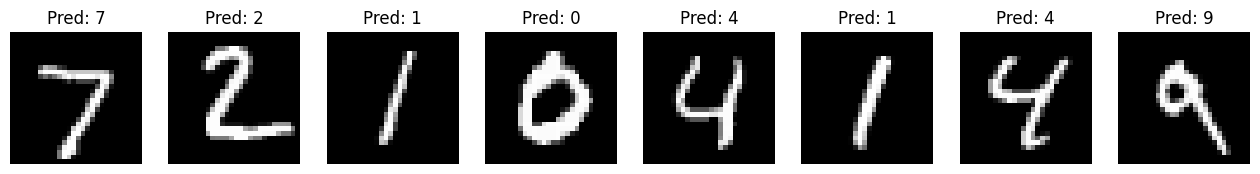

In [26]:

model_cnn_classifier.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model_cnn_classifier(images)
    _, preds = torch.max(outputs, 1)

# Show the first 8 images and their predicted labels
fig, axes = plt.subplots(1, 8, figsize=(16,2))
for i in range(8):
    axes[i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[i].set_title(f'Pred: {preds[i].item()}')
    axes[i].axis('off')
plt.show()

Classification accuracy on the original dataset

In [32]:
model_deep.eval()

model_cnn_classifier.eval()

def accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    return (predicted == labels).float().mean()

criterion = nn.CrossEntropyLoss()

test_running_loss = 0.0
test_running_acc = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model_cnn_classifier(images)
        
        # Compute loss and accuracy
        loss = criterion(outputs, labels)
        test_running_loss += loss.item()
        test_running_acc += accuracy(outputs, labels).item()


avg_test_loss = test_running_loss / len(test_loader)
avg_test_acc = test_running_acc / len(test_loader)

print(f"Classification on Images - "
        f"Loss: {avg_test_loss:.4f}, Acc: {avg_test_acc*100:.2f}%")

Classification on Images - Loss: 0.0431, Acc: 98.89%


Classification accuracy using the autoencoder reconstructed image as input

In [28]:
model_deep.eval()

model_cnn_classifier.eval()

def accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    return (predicted == labels).float().mean()

criterion = nn.CrossEntropyLoss()

test_running_loss = 0.0
test_running_acc = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Reconstruct the images using the autoencoder
        recon_images = model_deep(images)  
        
        # Classify the reconstructed images
        outputs = model_cnn_classifier(recon_images)
        
        # Compute loss and accuracy
        loss = criterion(outputs, labels)
        test_running_loss += loss.item()
        test_running_acc += accuracy(outputs, labels).item()


avg_test_loss = test_running_loss / len(test_loader)
avg_test_acc = test_running_acc / len(test_loader)

print(f"Classification on Reconstructed Images - "
        f"Loss: {avg_test_loss:.4f}, Acc: {avg_test_acc*100:.2f}%")

Classification on Reconstructed Images - Loss: 0.0745, Acc: 98.27%


setting up for classification using PCA, we are creating a DataLoader filled with the recostructed images of PCA

In [29]:
import torch
from torch.utils.data import Dataset, DataLoader

class PCATestDataset(Dataset):
    def __init__(self, images_2d, labels):
        
        self.images = images_2d
        self.labels = labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Get flattened data of shape 
        x = self.images[idx]
        label = self.labels[idx]
        # Reshape from [784] -> [1, 28, 28]
        x = x.reshape(1, 28, 28)
        # Convert to torch tensor
        x_tensor = torch.tensor(x, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return x_tensor, label_tensor

# Create a test dataset and loader for PCA-reconstructed images
pca_test_dataset = PCATestDataset(test_recon, test_labels_np)
pca_test_loader = DataLoader(pca_test_dataset, batch_size=64, shuffle=False)

outputing some samples of the pca_test_loader 

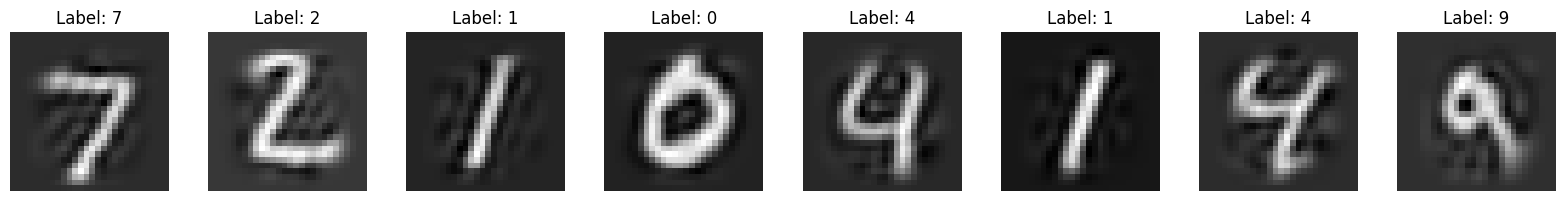

In [30]:
# Grab one batch from the PCA-reconstructed DataLoader
images, labels = next(iter(pca_test_loader))


num_images = 8
fig, axes = plt.subplots(1, num_images, figsize=(2 * num_images, 2))
for i in range(num_images):
    img_2d = images[i][0].cpu().numpy()
    axes[i].imshow(img_2d, cmap='gray')
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

Classification accuracy on the PCA reconstructed images

In [33]:
model_cnn_classifier.eval()

def accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    return (predicted == labels).float().mean()

criterion = nn.CrossEntropyLoss()

test_running_loss = 0.0
test_running_acc = 0.0

with torch.no_grad():
    for images, labels in pca_test_loader:
        images, labels = images.to(device), labels.to(device) 
        
        # Classify the reconstructed images
        outputs = model_cnn_classifier(images)
        
        # Compute loss and accuracy
        loss = criterion(outputs, labels)
        test_running_loss += loss.item()
        test_running_acc += accuracy(outputs, labels).item()


avg_test_loss = test_running_loss / len(test_loader)
avg_test_acc = test_running_acc / len(test_loader)

print(f"Classification on Reconstructed Images - "
        f"Loss: {avg_test_loss:.4f}, Acc: {avg_test_acc*100:.2f}%")

Classification on Reconstructed Images - Loss: 0.0564, Acc: 98.22%
